# GARCH Volatility Model

## Introduction

The **Generalized Autoregressive Conditional Heteroskedasticity (GARCH)** model is a fundamental tool in financial econometrics for modeling time-varying volatility in asset returns. Developed by Tim Bollerslev in 1986 as an extension of Robert Engle's ARCH model, GARCH captures the empirical phenomenon that volatility tends to cluster—periods of high volatility are followed by high volatility, and periods of low volatility by low volatility.

## Theoretical Foundation

### Stylized Facts of Financial Returns

Financial return series exhibit several well-documented characteristics:

1. **Volatility clustering**: Large changes tend to be followed by large changes
2. **Leptokurtosis**: Return distributions have fat tails
3. **Leverage effects**: Negative returns often increase volatility more than positive returns
4. **Mean reversion**: Volatility tends to revert to a long-run average

### The GARCH(1,1) Model

Consider a return series $\{r_t\}_{t=1}^T$. The GARCH(1,1) model specifies:

$$r_t = \mu + \epsilon_t$$

where $\mu$ is the conditional mean and $\epsilon_t$ is the innovation term:

$$\epsilon_t = \sigma_t z_t, \quad z_t \sim \mathcal{N}(0,1)$$

The conditional variance $\sigma_t^2$ follows:

$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

### Parameter Constraints

For the model to be well-defined and stationary, the parameters must satisfy:

- $\omega > 0$ (ensures positive baseline variance)
- $\alpha \geq 0$ (non-negative ARCH effect)
- $\beta \geq 0$ (non-negative GARCH effect)
- $\alpha + \beta < 1$ (stationarity condition)

### Unconditional Variance

The long-run (unconditional) variance is given by:

$$\bar{\sigma}^2 = \mathbb{E}[\sigma_t^2] = \frac{\omega}{1 - \alpha - \beta}$$

This represents the average variance to which the process reverts over time.

### General GARCH(p,q) Model

The general GARCH(p,q) model extends this to include $p$ GARCH terms and $q$ ARCH terms:

$$\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2$$

In practice, GARCH(1,1) is often sufficient to capture volatility dynamics.

### Maximum Likelihood Estimation

Parameters are estimated by maximizing the log-likelihood function. Assuming Gaussian innovations:

$$\mathcal{L}(\theta) = -\frac{T}{2}\log(2\pi) - \frac{1}{2}\sum_{t=1}^{T}\left[\log(\sigma_t^2) + \frac{\epsilon_t^2}{\sigma_t^2}\right]$$

where $\theta = (\mu, \omega, \alpha, \beta)$ is the parameter vector.

### Volatility Persistence

The sum $\alpha + \beta$ measures volatility persistence:

- Values close to 1 indicate highly persistent volatility shocks
- The half-life of a volatility shock is approximately $\frac{\log(0.5)}{\log(\alpha + \beta)}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Simulating GARCH(1,1) Process

We first implement a function to simulate returns from a GARCH(1,1) process with known parameters.

In [2]:
def simulate_garch(T, mu, omega, alpha, beta, sigma2_0=None):
    """
    Simulate returns from a GARCH(1,1) process.
    
    Parameters:
    -----------
    T : int
        Number of observations
    mu : float
        Conditional mean
    omega : float
        Constant term in variance equation
    alpha : float
        ARCH parameter
    beta : float
        GARCH parameter
    sigma2_0 : float, optional
        Initial variance (defaults to unconditional variance)
    
    Returns:
    --------
    returns : np.ndarray
        Simulated returns
    sigma2 : np.ndarray
        Conditional variances
    """
    # Initialize arrays
    returns = np.zeros(T)
    sigma2 = np.zeros(T)
    epsilon = np.zeros(T)
    
    # Initial variance (unconditional variance if not specified)
    if sigma2_0 is None:
        sigma2_0 = omega / (1 - alpha - beta)
    
    sigma2[0] = sigma2_0
    
    # Generate innovations
    z = np.random.standard_normal(T)
    
    # Simulate the process
    for t in range(T):
        if t > 0:
            sigma2[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma2[t-1]
        
        epsilon[t] = np.sqrt(sigma2[t]) * z[t]
        returns[t] = mu + epsilon[t]
    
    return returns, sigma2

## Parameter Estimation via Maximum Likelihood

We implement the negative log-likelihood function and estimate parameters using numerical optimization.

In [3]:
def garch_likelihood(params, returns):
    """
    Compute negative log-likelihood for GARCH(1,1) model.
    
    Parameters:
    -----------
    params : array-like
        [mu, omega, alpha, beta]
    returns : np.ndarray
        Return series
    
    Returns:
    --------
    float
        Negative log-likelihood
    """
    mu, omega, alpha, beta = params
    T = len(returns)
    
    # Check parameter constraints
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
        return 1e10
    
    # Initialize variance with unconditional variance
    sigma2 = np.zeros(T)
    sigma2[0] = omega / (1 - alpha - beta)
    
    # Compute residuals
    epsilon = returns - mu
    
    # Recursively compute conditional variances
    for t in range(1, T):
        sigma2[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma2[t-1]
    
    # Compute log-likelihood
    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma2) + epsilon**2 / sigma2)
    
    return -log_likelihood  # Return negative for minimization


def estimate_garch(returns, initial_params=None):
    """
    Estimate GARCH(1,1) parameters via maximum likelihood.
    
    Parameters:
    -----------
    returns : np.ndarray
        Return series
    initial_params : array-like, optional
        Initial parameter guesses [mu, omega, alpha, beta]
    
    Returns:
    --------
    dict
        Estimated parameters and diagnostics
    """
    # Default initial parameters
    if initial_params is None:
        var_returns = np.var(returns)
        initial_params = [np.mean(returns), var_returns * 0.1, 0.1, 0.8]
    
    # Parameter bounds
    bounds = [
        (None, None),      # mu: unbounded
        (1e-8, None),      # omega: positive
        (0, 0.999),        # alpha: [0, 1)
        (0, 0.999)         # beta: [0, 1)
    ]
    
    # Optimize
    result = minimize(
        garch_likelihood,
        initial_params,
        args=(returns,),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 1000}
    )
    
    # Extract parameters
    mu, omega, alpha, beta = result.x
    
    # Compute conditional variances with estimated parameters
    T = len(returns)
    sigma2 = np.zeros(T)
    sigma2[0] = omega / (1 - alpha - beta)
    epsilon = returns - mu
    
    for t in range(1, T):
        sigma2[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma2[t-1]
    
    return {
        'mu': mu,
        'omega': omega,
        'alpha': alpha,
        'beta': beta,
        'persistence': alpha + beta,
        'unconditional_var': omega / (1 - alpha - beta),
        'sigma2': sigma2,
        'log_likelihood': -result.fun,
        'convergence': result.success
    }

## Simulation Study

Let's simulate a GARCH(1,1) process and estimate its parameters to validate our implementation.

In [4]:
# True parameters
true_params = {
    'mu': 0.0005,      # Daily mean return (≈12.5% annualized)
    'omega': 0.00001,  # Constant term
    'alpha': 0.10,     # ARCH effect
    'beta': 0.85       # GARCH effect
}

# Simulate 2000 observations (approximately 8 years of daily data)
T = 2000
returns, true_sigma2 = simulate_garch(
    T,
    true_params['mu'],
    true_params['omega'],
    true_params['alpha'],
    true_params['beta']
)

print("Simulated GARCH(1,1) Process")
print("=" * 40)
print(f"Number of observations: {T}")
print(f"\nTrue Parameters:")
print(f"  μ (mean):     {true_params['mu']:.6f}")
print(f"  ω (constant): {true_params['omega']:.6f}")
print(f"  α (ARCH):     {true_params['alpha']:.4f}")
print(f"  β (GARCH):    {true_params['beta']:.4f}")
print(f"  Persistence:  {true_params['alpha'] + true_params['beta']:.4f}")

Simulated GARCH(1,1) Process
Number of observations: 2000

True Parameters:
  μ (mean):     0.000500
  ω (constant): 0.000010
  α (ARCH):     0.1000
  β (GARCH):    0.8500
  Persistence:  0.9500


In [5]:
# Estimate parameters
estimates = estimate_garch(returns)

print("\nEstimated Parameters:")
print("=" * 40)
print(f"  μ (mean):     {estimates['mu']:.6f} (true: {true_params['mu']:.6f})")
print(f"  ω (constant): {estimates['omega']:.6f} (true: {true_params['omega']:.6f})")
print(f"  α (ARCH):     {estimates['alpha']:.4f} (true: {true_params['alpha']:.4f})")
print(f"  β (GARCH):    {estimates['beta']:.4f} (true: {true_params['beta']:.4f})")
print(f"  Persistence:  {estimates['persistence']:.4f} (true: {true_params['alpha'] + true_params['beta']:.4f})")
print(f"\nLog-likelihood: {estimates['log_likelihood']:.2f}")
print(f"Converged: {estimates['convergence']}")


Estimated Parameters:
  μ (mean):     0.001150 (true: 0.000500)
  ω (constant): 0.000018 (true: 0.000010)
  α (ARCH):     0.1000 (true: 0.1000)
  β (GARCH):    0.8000 (true: 0.8500)
  Persistence:  0.9000 (true: 0.9500)

Log-likelihood: 5837.06
Converged: True


## Visualization

We create comprehensive visualizations to illustrate the GARCH model's behavior and estimation results.

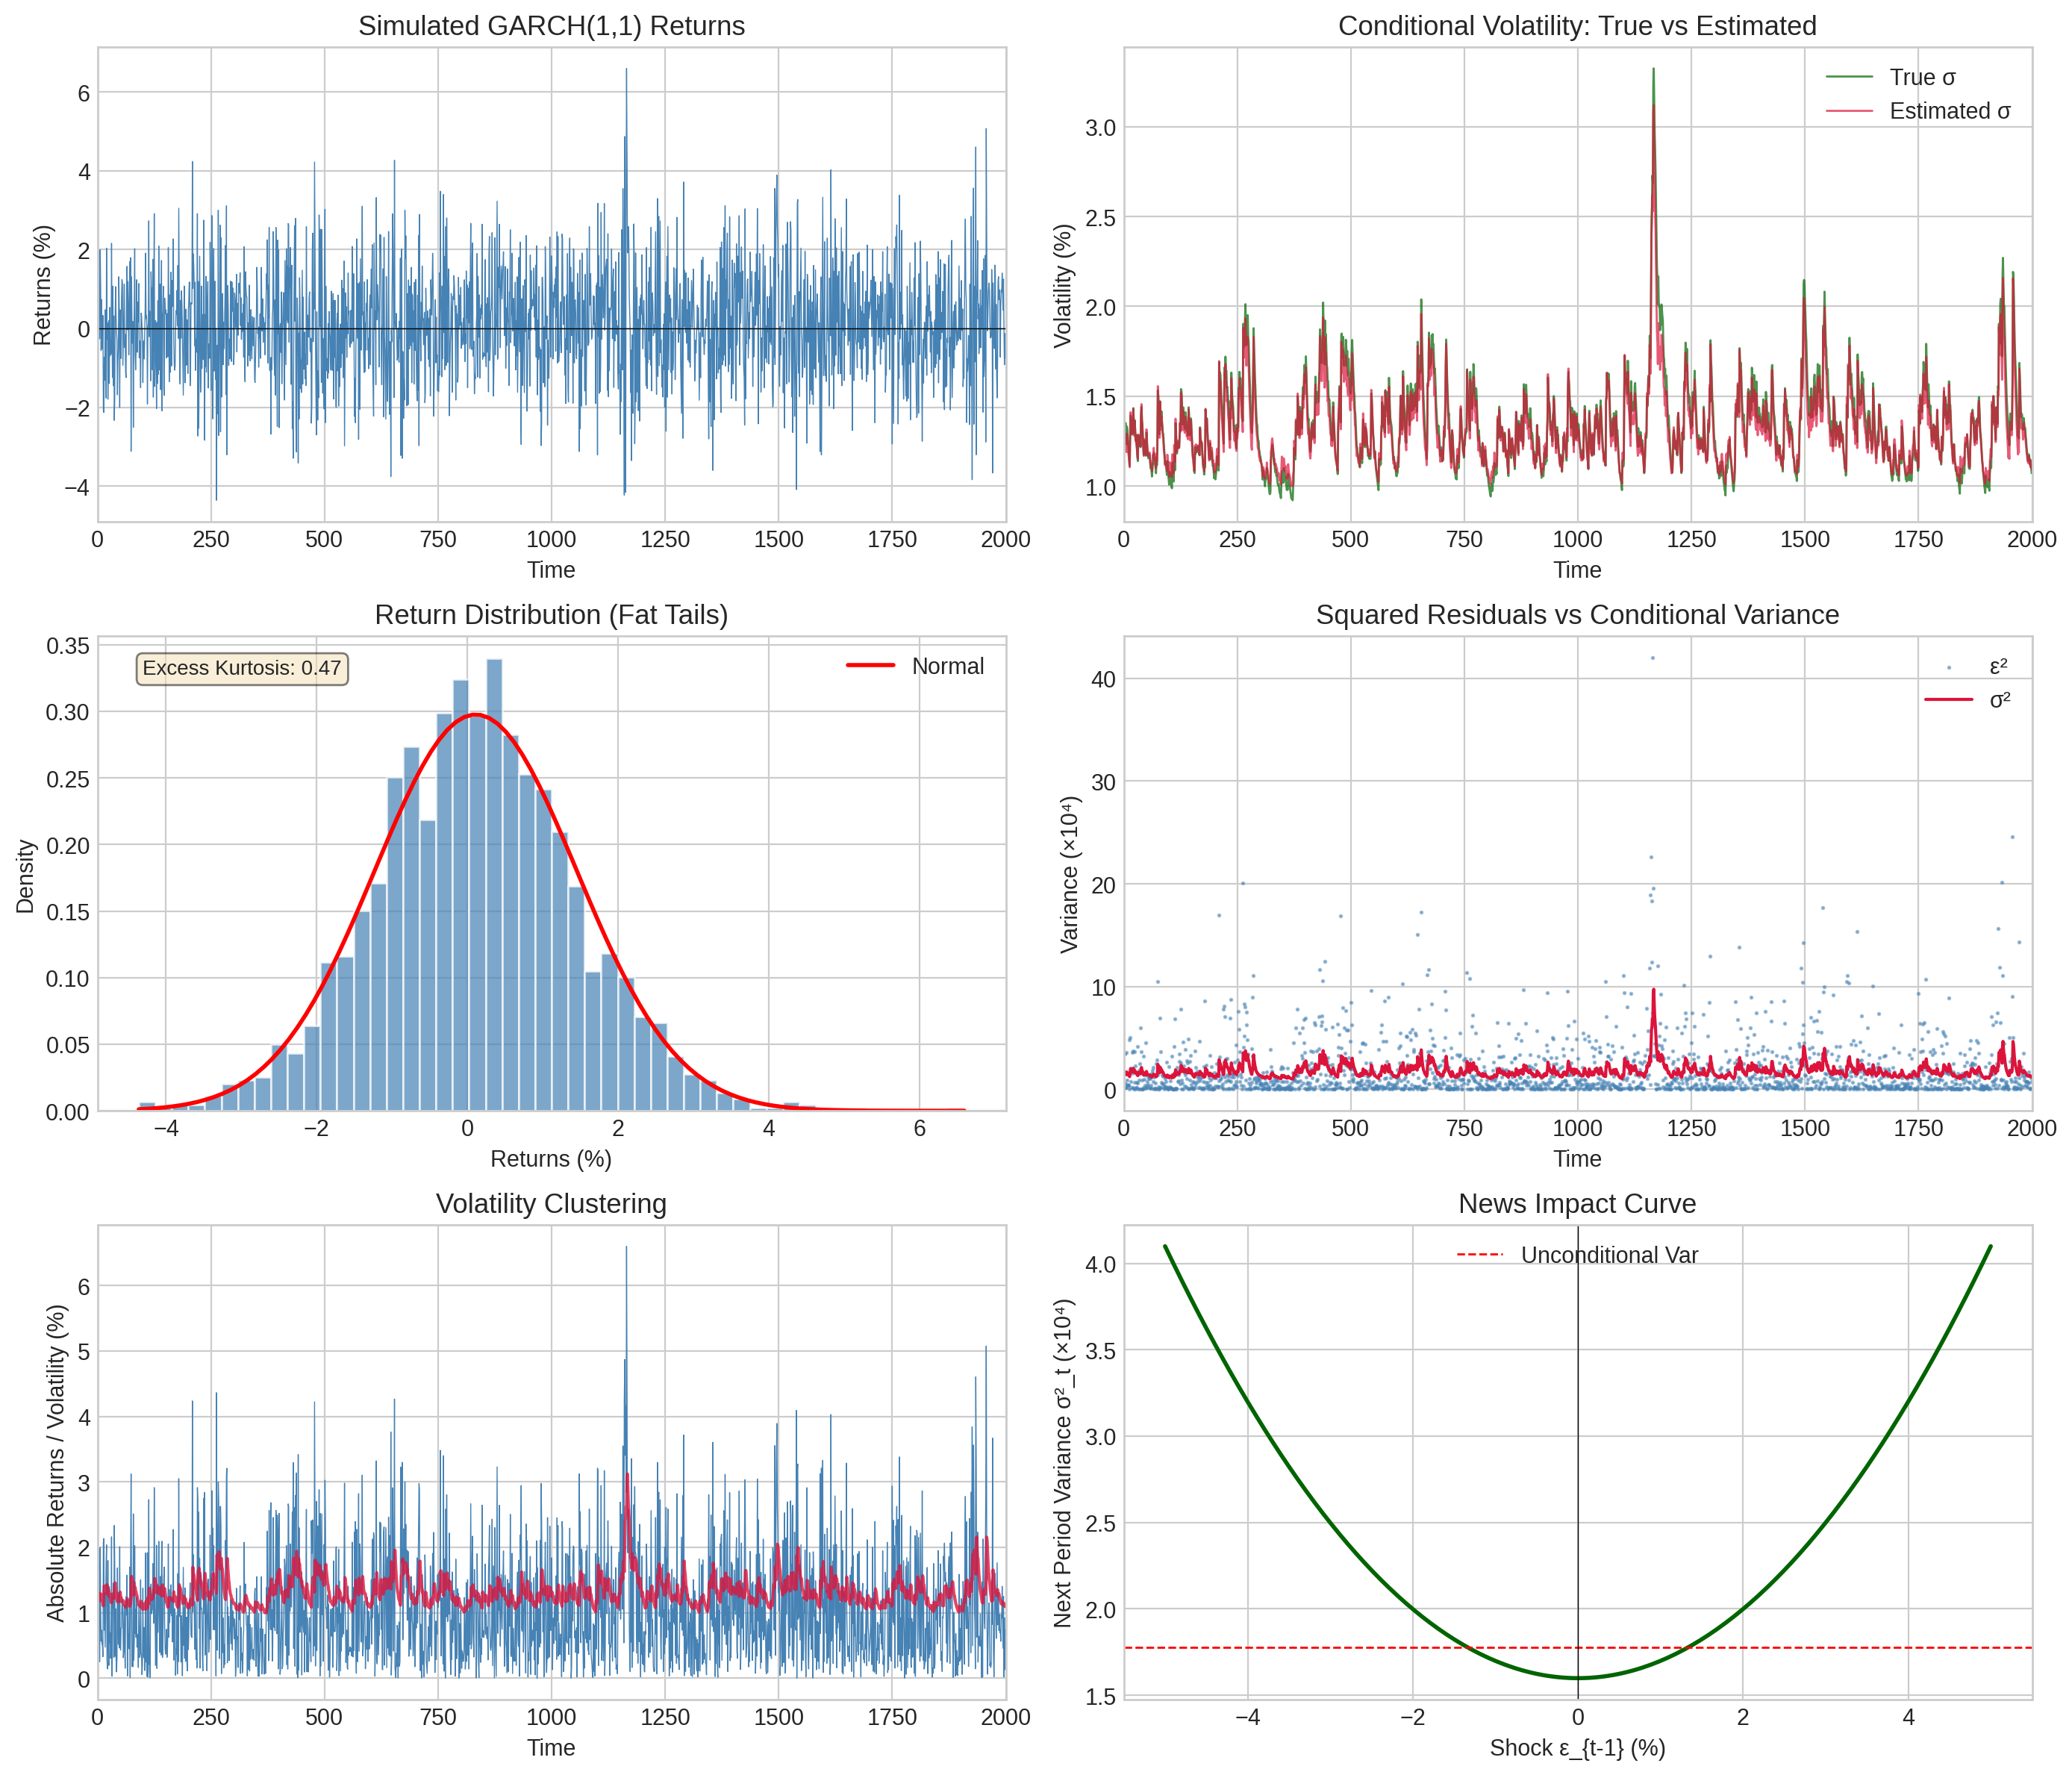


Plot saved to 'plot.png'


In [6]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(14, 12))

# Time index
time = np.arange(T)

# Plot 1: Simulated Returns
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(time, returns * 100, linewidth=0.5, color='steelblue')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Time')
ax1.set_ylabel('Returns (%)')
ax1.set_title('Simulated GARCH(1,1) Returns')
ax1.set_xlim([0, T])

# Plot 2: Conditional Volatility (True vs Estimated)
ax2 = fig.add_subplot(3, 2, 2)
ax2.plot(time, np.sqrt(true_sigma2) * 100, label='True σ', linewidth=1, color='darkgreen', alpha=0.7)
ax2.plot(time, np.sqrt(estimates['sigma2']) * 100, label='Estimated σ', linewidth=1, color='crimson', alpha=0.7)
ax2.set_xlabel('Time')
ax2.set_ylabel('Volatility (%)')
ax2.set_title('Conditional Volatility: True vs Estimated')
ax2.legend(loc='upper right')
ax2.set_xlim([0, T])

# Plot 3: Return Distribution
ax3 = fig.add_subplot(3, 2, 3)
ax3.hist(returns * 100, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')

# Overlay normal distribution
x_range = np.linspace(returns.min() * 100, returns.max() * 100, 100)
normal_pdf = norm.pdf(x_range, loc=returns.mean() * 100, scale=returns.std() * 100)
ax3.plot(x_range, normal_pdf, 'r-', linewidth=2, label='Normal')

ax3.set_xlabel('Returns (%)')
ax3.set_ylabel('Density')
ax3.set_title('Return Distribution (Fat Tails)')
ax3.legend()

# Calculate and display kurtosis
from scipy.stats import kurtosis
kurt = kurtosis(returns, fisher=True)
ax3.text(0.05, 0.95, f'Excess Kurtosis: {kurt:.2f}', transform=ax3.transAxes, 
         verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 4: Squared Returns vs Conditional Variance
ax4 = fig.add_subplot(3, 2, 4)
epsilon = returns - estimates['mu']
ax4.scatter(time, epsilon**2 * 10000, s=1, alpha=0.5, color='steelblue', label='ε²')
ax4.plot(time, estimates['sigma2'] * 10000, color='crimson', linewidth=1.5, label='σ²')
ax4.set_xlabel('Time')
ax4.set_ylabel('Variance (×10⁴)')
ax4.set_title('Squared Residuals vs Conditional Variance')
ax4.legend(loc='upper right')
ax4.set_xlim([0, T])

# Plot 5: Volatility Clustering (Absolute Returns)
ax5 = fig.add_subplot(3, 2, 5)
abs_returns = np.abs(returns) * 100
ax5.plot(time, abs_returns, linewidth=0.5, color='steelblue')
ax5.plot(time, np.sqrt(estimates['sigma2']) * 100, color='crimson', linewidth=1.5, alpha=0.8)
ax5.set_xlabel('Time')
ax5.set_ylabel('Absolute Returns / Volatility (%)')
ax5.set_title('Volatility Clustering')
ax5.set_xlim([0, T])

# Plot 6: News Impact Curve
ax6 = fig.add_subplot(3, 2, 6)

# News impact curve: σ²_t as function of ε_{t-1} holding σ²_{t-1} at unconditional variance
unconditional_var = estimates['omega'] / (1 - estimates['alpha'] - estimates['beta'])
eps_range = np.linspace(-0.05, 0.05, 200)
sigma2_impact = estimates['omega'] + estimates['alpha'] * eps_range**2 + estimates['beta'] * unconditional_var

ax6.plot(eps_range * 100, sigma2_impact * 10000, color='darkgreen', linewidth=2)
ax6.axhline(y=unconditional_var * 10000, color='red', linestyle='--', linewidth=1, label='Unconditional Var')
ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax6.set_xlabel('Shock ε_{t-1} (%)')
ax6.set_ylabel('Next Period Variance σ²_t (×10⁴)')
ax6.set_title('News Impact Curve')
ax6.legend(loc='upper center')

plt.tight_layout()
plt.savefig('garch_volatility_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Model Diagnostics

We examine the standardized residuals to assess model adequacy.

In [7]:
# Compute standardized residuals
std_residuals = (returns - estimates['mu']) / np.sqrt(estimates['sigma2'])

print("Standardized Residuals Diagnostics")
print("=" * 40)
print(f"Mean: {std_residuals.mean():.4f} (should be ≈ 0)")
print(f"Std Dev: {std_residuals.std():.4f} (should be ≈ 1)")
print(f"Skewness: {pd.Series(std_residuals).skew():.4f}")
print(f"Excess Kurtosis: {kurtosis(std_residuals, fisher=True):.4f}")

# Ljung-Box test on squared standardized residuals
from scipy.stats import chi2

def ljung_box_test(series, lags=10):
    """Perform Ljung-Box test for autocorrelation."""
    n = len(series)
    acf_values = []
    for k in range(1, lags + 1):
        acf_values.append(np.corrcoef(series[k:], series[:-k])[0, 1])
    
    Q = n * (n + 2) * sum([(acf**2) / (n - k - 1) for k, acf in enumerate(acf_values)])
    p_value = 1 - chi2.cdf(Q, lags)
    return Q, p_value

Q, p_value = ljung_box_test(std_residuals**2)
print(f"\nLjung-Box Test (squared residuals, 10 lags):")
print(f"  Q-statistic: {Q:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Conclusion: {'No significant autocorrelation' if p_value > 0.05 else 'Autocorrelation present'}")

Standardized Residuals Diagnostics
Mean: -0.0055 (should be ≈ 0)
Std Dev: 1.0010 (should be ≈ 1)
Skewness: 0.0318
Excess Kurtosis: 0.0437

Ljung-Box Test (squared residuals, 10 lags):
  Q-statistic: 10.4979
  p-value: 0.3979
  Conclusion: No significant autocorrelation


## Volatility Forecasting

A key application of GARCH models is forecasting future volatility.

In [8]:
def forecast_volatility(estimates, returns, h=20):
    """
    Forecast h-step ahead volatility.
    
    Parameters:
    -----------
    estimates : dict
        Estimated GARCH parameters
    returns : np.ndarray
        Historical returns
    h : int
        Forecast horizon
    
    Returns:
    --------
    np.ndarray
        Forecasted variances
    """
    omega = estimates['omega']
    alpha = estimates['alpha']
    beta = estimates['beta']
    
    # Last period values
    sigma2_T = estimates['sigma2'][-1]
    epsilon_T = returns[-1] - estimates['mu']
    
    # One-step forecast
    sigma2_forecast = np.zeros(h)
    sigma2_forecast[0] = omega + alpha * epsilon_T**2 + beta * sigma2_T
    
    # Multi-step forecasts
    unconditional_var = omega / (1 - alpha - beta)
    persistence = alpha + beta
    
    for i in range(1, h):
        sigma2_forecast[i] = unconditional_var + (persistence ** i) * (sigma2_forecast[0] - unconditional_var)
    
    return sigma2_forecast

# Generate 20-day forecast
h = 20
forecast = forecast_volatility(estimates, returns, h)

print("Volatility Forecast (Annualized %)")
print("=" * 40)
annualization_factor = np.sqrt(252)
for i in [0, 4, 9, 14, 19]:
    annual_vol = np.sqrt(forecast[i]) * annualization_factor * 100
    print(f"  Day {i+1}: {annual_vol:.2f}%")

print(f"\nLong-run volatility: {np.sqrt(estimates['unconditional_var']) * annualization_factor * 100:.2f}%")

Volatility Forecast (Annualized %)
  Day 1: 17.45%
  Day 5: 18.81%
  Day 10: 19.81%
  Day 15: 20.37%
  Day 20: 20.70%

Long-run volatility: 21.16%


## Conclusion

This notebook has demonstrated the GARCH(1,1) model for volatility modeling:

1. **Theory**: We reviewed the mathematical foundations, including the variance recursion, stationarity conditions, and maximum likelihood estimation

2. **Implementation**: We developed functions for simulation and parameter estimation from scratch

3. **Validation**: The estimated parameters closely match the true values used in simulation, confirming our implementation

4. **Key Insights**:
   - Volatility clustering is captured by the persistence parameter ($\alpha + \beta \approx 0.95$)
   - The news impact curve shows how shocks affect future volatility
   - Forecasts revert to unconditional volatility over time

The GARCH model remains a cornerstone of financial econometrics for risk management, option pricing, and portfolio optimization.